# Analyse des ventes pour Lapage v1 (02/2023, Kamel Badar)

# 1 Introduction

## 1.1 Importation des librairies

Ce notebook sera divisé en plusieurs parties : 
- L'import des données et la vérification de leur intégrité 
- L'analyse des indicateurs de vente
- Une recherche de corrélations 

In [1]:
# Importation des librairies nécessaires au projet

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import shapiro
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import plotly_express as px


## 1.2 Importation des données

In [2]:
# Importation des fichiers CSV

dataCustomers = pd.read_csv('customers.csv')
dataProducts = pd.read_csv('products.csv')
dataTransac = pd.read_csv ('transactions.csv')

In [3]:
# On check l'affichage des dataframes 

dataCustomers

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [4]:
dataProducts

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


Note : L'id_prod semble être une concaténation de la catégorie du produit ('categ') et d'un numero de produit (valeur non présente dans le dataset)

In [5]:
dataTransac

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


## 1.3 DF dataCustomers

In [6]:
# On décrit le DF

dataCustomers.describe(include='all')

,client_id,sex,birth
count,8623,8623,8623.000000
unique,8623,2,NaN
top,c_4410,f,NaN
freq,1,4491,NaN
mean,NaN,NaN,1978.280877
std,NaN,NaN,16.919535
min,NaN,NaN,1929.000000
25%,NaN,NaN,1966.000000
50%,NaN,NaN,1979.000000
75%,NaN,NaN,1992.000000


In [7]:
# On check les types de données

dataCustomers.dtypes

client_id    object
sex          object
birth         int64
dtype: object

Les types de données sont adéquats

In [8]:
# On cherche la présence de valeurs manquantes

dataCustomers.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

Il n'y a pas de valeurs manquantes

In [9]:
# On cherche la présence de doublons 

dataCustomers['client_id'].duplicated().any()

False

Il n'y a pas de doublons non plus pour la colonne client_id

## 1.4 DF dataProducts

In [10]:
# On décrit le DF

dataProducts.describe(include='all')

,id_prod,price,categ
count,3287,3287.000000,3287.000000
unique,3287,NaN,NaN
top,0_1421,NaN,NaN
freq,1,NaN,NaN
mean,NaN,21.856641,0.370246
std,NaN,29.847908,0.615387
min,NaN,-1.000000,0.000000
25%,NaN,6.990000,0.000000
50%,NaN,13.060000,0.000000
75%,NaN,22.990000,1.000000


In [11]:
# On check les types de données

dataProducts.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

Les types semblent adéquats

In [12]:
# On cherche la présence de valeurs manquantes

dataProducts.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

Il n'y a pas de valeurs manquantes

In [13]:
# On cherche la présence de doublons 

dataProducts['id_prod'].duplicated().any()

False

Il n'y a pas de doublons pour la colonne 'id_prod'

## 1.5 DF dataTransac

In [14]:
# On décrit le DF

dataTransac.describe(include='all')

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


On constate que la dernière transaction a lieu le 28/02/2023 ce qui est impossible car cette date n'est pas encore passée au moment de l'analyse. Nous allons y remedier plus tard. 

In [15]:
# On check les types de données

dataTransac.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

Les types de données sont adéquats à part la colonne date qui n'a pas le bon type. Il faut découvrir la raison. 

In [16]:
# On check les valeurs manquantes 

dataTransac.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

Il n'y a pas de valeurs manquantes

In [17]:
# On check la présence de doublons

dataTransac.duplicated().sum()

126

### 1.5.1 Doublons et données de test 

Il y a un certain nombre de doublons dans ce DF. Il faut comprendre en les raisons.

In [18]:
# On stocke les doublons dans un nouvel objet pour les afficher

duplicatedTransacs = dataTransac[dataTransac.duplicated()]
print(duplicatedTransacs)

       id_prod                             date session_id client_id
27778      T_0  test_2021-03-01 02:30:02.237437        s_0      ct_1
52424      T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
96687      T_0  test_2021-03-01 02:30:02.237412        s_0      ct_1
130188     T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
139339     T_0  test_2021-03-01 02:30:02.237443        s_0      ct_1
...        ...                              ...        ...       ...
653098     T_0  test_2021-03-01 02:30:02.237432        s_0      ct_0
657830     T_0  test_2021-03-01 02:30:02.237417        s_0      ct_0
662081     T_0  test_2021-03-01 02:30:02.237427        s_0      ct_1
671647     T_0  test_2021-03-01 02:30:02.237424        s_0      ct_1
679180     T_0  test_2021-03-01 02:30:02.237425        s_0      ct_1

[126 rows x 4 columns]


On constate que les lignes doublons présentent les mêmes caractéristiques : la valeur pour 'id_prod' est le même en l'ocurrence 'T_0' et même chose pour le 'session_id'. Deux indices peuvent laisser penser qu'il s'agit ici de données issues de tests : la présence du mot 'test' devant la date , et le fait que les valeurs pour client_id commencent par 'ct' qui pourrait signifier client test. 

In [19]:
duplicatedTransacs['id_prod'].unique()

array(['T_0'], dtype=object)

In [20]:
duplicatedTransacs['session_id'].unique()

array(['s_0'], dtype=object)

In [21]:
# On effectue un test visant à chercher la présence de la chaîne de caractères 'test' dans la colonne 'date' du DF composé des doublons

testError = duplicatedTransacs[duplicatedTransacs['date'].str.contains('test')]
testError


,id_prod,date,session_id,client_id
27778,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
52424,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
96687,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
130188,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
139339,T_0,test_2021-03-01 02:30:02.237443,s_0,ct_1
...,...,...,...,...
653098,T_0,test_2021-03-01 02:30:02.237432,s_0,ct_0
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


Grâce à cette vérification, on à la certitude que la totalité des doublons sont issues des données de test. 

In [22]:
# On supprime les doublons en gardant uniquement les lignes qui ne contiennent pas le substring 'test' 

dataTransac = dataTransac[~dataTransac['date'].str.contains('test')]

In [23]:
# On supprime du DF dataProducts les références qui correspondent aux produits test

dataProducts = dataProducts.loc[dataProducts['id_prod'] != 'T_0', :]


In [24]:
# On check les doublons

dataTransac.duplicated().any()

False

On a dédoublonné le jeu de données, et supprimé les valeurs posant problème pour la conversion au type datetime.

### 1.5.2 Conversion au format date et suppression des données du futur

In [25]:
# On convertit maintenant la colonne au format datetime

dataTransac['date'] = pd.to_datetime(dataTransac['date'])
dataTransac

C:\Users\kamel\AppData\Local\Temp\ipykernel_19432\2482561944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataTransac['date'] = pd.to_datetime(dataTransac['date'])


,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


La conversion au type datetime s'est déroulée correctement 

In [26]:
# On exclut les transactions dont la date est dans le futur 

dataTransac = dataTransac.loc[dataTransac["date"]<"2023-02-11",:]
dataTransac.sort_values(by='date', ascending=False)

,id_prod,date,session_id,client_id
52881,1_676,2023-02-10 23:59:59.414026,s_339757,c_999
472085,1_504,2023-02-10 23:59:10.000890,s_339756,c_5334
35020,1_524,2023-02-10 23:56:07.389436,s_339755,c_2072
355172,1_607,2023-02-10 23:55:48.648542,s_339755,c_2072
571008,1_667,2023-02-10 23:54:30.702796,s_339754,c_4850
...,...,...,...,...
439073,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033
488300,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912
462702,0_1352,2021-03-01 00:02:38.311413,s_3,c_580
428477,0_1390,2021-03-01 00:02:26.047414,s_2,c_664


## 1.6 Jointure des fichiers

### 1.6.1 Première jointure 

In [27]:
# On joint les données client aux données de transaction dans un nouveau DF

dataMerged = pd.merge(dataTransac, dataCustomers, how='outer', on='client_id')
dataMerged

,id_prod,date,session_id,client_id,sex,birth
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986
1,0_1627,2022-06-18 05:55:31.816994,s_225494,c_103,f,1986
2,0_1104,2023-02-08 17:31:06.898425,s_338755,c_103,f,1986
3,0_1390,2021-04-20 06:18:39.939761,s_23078,c_103,f,1986
4,0_1547,2022-03-15 19:54:53.904123,s_179629,c_103,f,1986
...,...,...,...,...,...,...
662480,NaN,NaT,NaN,c_7584,f,1960
662481,NaN,NaT,NaN,c_90,m,2001
662482,NaN,NaT,NaN,c_587,m,1993
662483,NaN,NaT,NaN,ct_1,m,2001


On constate que les 5 dernières lignes du DF fusionné ont des valeurs manquantes pour la partie correspondant à la transaction. On partira du principe qu'il s'agit de clients qui n'ont réalisé aucun achat depuis leur inscription.

### 1.6.2 Clients sans achats

In [28]:
# On affiche la liste des clients sans achats depuis l'inscription

noPurchaseCustomers = dataMerged.loc[dataMerged['id_prod'].isnull(), :]
noPurchaseCustomers

,id_prod,date,session_id,client_id,sex,birth
662462,NaN,NaT,NaN,c_8253,f,2001
662463,NaN,NaT,NaN,c_3789,f,1997
662464,NaN,NaT,NaN,c_4406,f,1998
662465,NaN,NaT,NaN,ct_0,f,2001
662466,NaN,NaT,NaN,c_2706,f,1967
662467,NaN,NaT,NaN,c_3443,m,1959
662468,NaN,NaT,NaN,c_4447,m,1956
662469,NaN,NaT,NaN,c_3017,f,1992
662470,NaN,NaT,NaN,c_4086,f,1992
662471,NaN,NaT,NaN,c_6930,m,2004


In [29]:
noPurchaseCustomers.nunique()

id_prod        0
date           0
session_id     0
client_id     23
sex            2
birth         15
dtype: int64

On constate donc qu'il y a 23 clients qui n'ont jamais effectué d'achats sur le site depuis leur inscription. 

### 1.6.3 Deuxième jointure

In [30]:
# On joint les données produit au DF précédent en incluant une colonne qui check la bonne réalisation de la jointure pour chaque ligne

dataSales = pd.merge(dataMerged, dataProducts, how='outer', on='id_prod')
dataSales['merge_check'] = (dataSales['price'].notna() & dataSales['categ'].notna()).astype(int)
dataSales


,id_prod,date,session_id,client_id,sex,birth,price,categ,merge_check
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986.0,4.18,0.0,1
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986.0,4.18,0.0,1
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986.0,4.18,0.0,1
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968.0,4.18,0.0,1
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968.0,4.18,0.0,1
...,...,...,...,...,...,...,...,...,...
662501,0_1624,NaT,NaN,NaN,NaN,NaN,24.50,0.0,1
662502,2_86,NaT,NaN,NaN,NaN,NaN,132.36,2.0,1
662503,0_299,NaT,NaN,NaN,NaN,NaN,22.99,0.0,1
662504,0_510,NaT,NaN,NaN,NaN,NaN,23.66,0.0,1


Les deux valeurs pouvant apparaître dans la colonne sont 0 et 1. Si c'est 0, la jointure a echoué pour cette ligne et si c'est 1, la jointure a fonctionné

In [31]:
# On crée un DF qui stocke les lignes où la jointure a échoué

testMergeFinal = dataSales[dataSales['merge_check']==0]
testMergeFinal

,id_prod,date,session_id,client_id,sex,birth,price,categ,merge_check
300941,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,f,1968.0,NaN,NaN,0
300942,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,f,1968.0,NaN,NaN,0
300943,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,f,1968.0,NaN,NaN,0
300944,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,f,1968.0,NaN,NaN,0
300945,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,f,1968.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
662480,NaN,NaT,NaN,c_7584,f,1960.0,NaN,NaN,0
662481,NaN,NaT,NaN,c_90,m,2001.0,NaN,NaN,0
662482,NaN,NaT,NaN,c_587,m,1993.0,NaN,NaN,0
662483,NaN,NaT,NaN,ct_1,m,2001.0,NaN,NaN,0


A première vue, la jointure n'a pas été effectuée pour les lignes qui ont pour valeur '0_2245' en 'id_prod' mais il faut vérifier. On constate également des valeurs nulles pour la colonne 'id prod' qui sont apparues post-jointure. On émet la même hypothèse que pour les clients sans achats. 

### 1.6.4 Produits sans achats

In [32]:
# On affiche la liste des produits sans achats depuis la création du site

noSalesProducts = dataSales.loc[dataSales['client_id'].isnull(), :]
noSalesProducts

,id_prod,date,session_id,client_id,sex,birth,price,categ,merge_check
662485,0_1016,NaT,NaN,NaN,NaN,NaN,35.06,0.0,1
662486,0_1780,NaT,NaN,NaN,NaN,NaN,1.67,0.0,1
662487,0_1062,NaT,NaN,NaN,NaN,NaN,20.08,0.0,1
662488,0_1119,NaT,NaN,NaN,NaN,NaN,2.99,0.0,1
662489,0_1014,NaT,NaN,NaN,NaN,NaN,1.15,0.0,1
662490,1_0,NaT,NaN,NaN,NaN,NaN,31.82,1.0,1
662491,0_1318,NaT,NaN,NaN,NaN,NaN,20.92,0.0,1
662492,0_1800,NaT,NaN,NaN,NaN,NaN,22.05,0.0,1
662493,0_1645,NaT,NaN,NaN,NaN,NaN,2.99,0.0,1
662494,0_322,NaT,NaN,NaN,NaN,NaN,2.99,0.0,1


In [33]:
noSalesProducts.nunique()

id_prod        21
date            0
session_id      0
client_id       0
sex             0
birth           0
price          19
categ           3
merge_check     1
dtype: int64

Il y a donc 21 produits qui n'ont jamais été acheté depuis la création du site web

### 1.6.5 La gestion des valeurs manquantes pour l'id_prod '0_2245' 

In [34]:
# On crée un DF qui stocke les lignes où id_prod = 0_2245

idProdCheck = testMergeFinal[testMergeFinal['id_prod'] == '0_2245']
idProdCheck

,id_prod,date,session_id,client_id,sex,birth,price,categ,merge_check
300941,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,f,1968.0,NaN,NaN,0
300942,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,f,1968.0,NaN,NaN,0
300943,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,f,1968.0,NaN,NaN,0
300944,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,f,1968.0,NaN,NaN,0
300945,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,f,1968.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
301153,0_2245,2022-06-09 09:12:02.773166,s_221070,c_7753,f,1973.0,NaN,NaN,0
301154,0_2245,2021-04-09 09:12:02.773166,s_18096,c_7753,f,1973.0,NaN,NaN,0
301155,0_2245,2021-08-22 08:51:27.564509,s_79102,c_6752,m,1987.0,NaN,NaN,0
301156,0_2245,2022-04-22 08:51:27.564509,s_197669,c_6752,m,1987.0,NaN,NaN,0


On a le même nombre de lignes, on peut donc en déduire que le problème vient de la valeur '0_2245'

In [35]:
# On check les valeurs 'price' et 'categ' pour 'id_prod' = '0_2245' dans le DF pré-jointure en les stockant dans un nouveau DF

id2245Check = dataProducts[dataProducts['id_prod']=='0_2245']
id2245Check

,id_prod,price,categ


On constate qu'on ne retrouve pas cette valeur pour 'id_prod' dans le dataframe contenant les informations produit, qui est censé à priori contenir la totalité des 'id_prod'. 

In [36]:
# On vérifie les lignes qui contiennent cette valeur dans le DF dataTransac

id2245CheckTransac = dataTransac[dataTransac['id_prod']=='0_2245']
id2245CheckTransac

,id_prod,date,session_id,client_id
2633,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746
10106,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713
11727,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108
15675,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391
16377,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954
...,...,...,...,...
669730,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131
670682,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167
671286,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453
675679,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098


Ce produit a effectivement été vendu 221 fois et il faut donc garder à l'esprit que nous ne disposons ni de son prix, ni de sa catégorie. 
Il y a environ 679 000 transactions, ce qui signifie que supprimer les 221 lignes correspondant à 0_2245 n'aura pas une grande incidence pour notre analyse. Imputer une valeur, même faible, pourrait par contre avoir une grande incidence sur le résulat de l'analyse.
Nous faisons donc le choix de les supprimer.

In [37]:
dataSales = dataSales[dataSales["id_prod"] != '0_2245']

In [38]:
dataSales.isna().sum()

id_prod        23
date           44
session_id     44
client_id      21
sex            21
birth          21
price          23
categ          23
merge_check     0
dtype: int64

Grâce à cette série de tests, on a pu déterminer l'origine des valeurs nulles dans ce nouveau DF. Si on soustrait 221 (nombre de transactions pour le produit '0_2245') à 240 (nombre total de lignes pour lesquelles le merge check affichait '0'), on obtient 21 ce qui est le nombre de valeurs manquantes que l'on avait identifié pour les produits sans achats. Il n'y a donc pas d'autre valeurs manquantes. Nous pouvons passer aux analyses.

# 2 Analyse des indicateurs de vente 

## 2.1 Chiffre d'affaires par produit

#### 2.1.1 Création d'un DF contenant le CA par produit

In [39]:
# On crée un dataframe groupé par 'id_prod' et on calcule la chiffre d'affaires ainsi que le nombre de ventes qu'on ajoute en colonne

dataTurnoverProducts = pd.DataFrame(dataSales.groupby('id_prod')['price'].sum()).reset_index()
dataTurnoverProducts.rename(columns = {'price':'turnover'}, inplace=True)
dataTurnoverProducts.head()

,id_prod,turnover
0,0_0,4545.00
1,0_1,5242.23
2,0_10,394.90
3,0_100,61.80
4,0_1000,2872.80


#### 2.1.2 Top 10 des produits en terme de CA généré 

In [40]:
dataTurnoverProducts.sort_values(by="turnover", ascending=False)

,id_prod,turnover
3114,2_159,92557.66
3088,2_135,67334.24
3063,2_112,63380.66
3052,2_102,58666.88
3170,2_209,55292.10
...,...,...
869,0_1780,1.67
318,0_1284,1.38
19,0_1014,1.15
601,0_1539,0.99


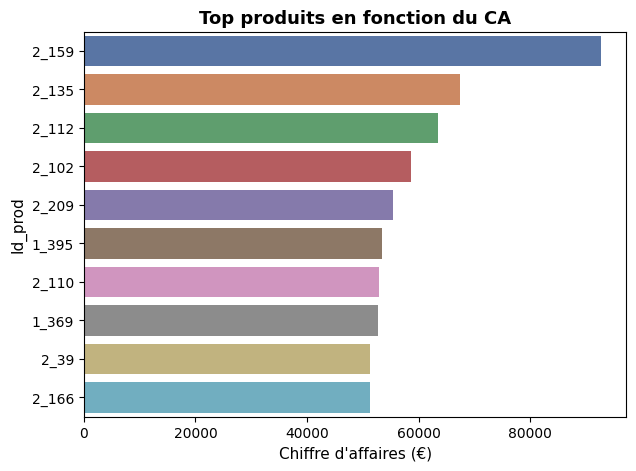

In [41]:
prod_top10 = dataTurnoverProducts.sort_values('turnover', ascending=False).head(10)
plt.figure(figsize=(7,5))
sns.barplot(x=prod_top10['turnover'], y=prod_top10['id_prod'], palette ='deep')
plt.title("Top produits en fonction du CA", fontsize=13, fontweight='bold')
plt.ylabel("Id_prod", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

Le produit ayant pour id '2_159' est de manière assez nette celui qui a généré le plus de CA avec 92 557.66 €

#### 2.1.3 Flop 10 des produits en terme de CA généré

In [42]:
dataTurnoverProducts.sort_values(by="turnover", ascending=True)

,id_prod,turnover
692,0_1620,0.80
601,0_1539,0.99
19,0_1014,1.15
318,0_1284,1.38
869,0_1780,1.67
...,...,...
3170,2_209,55292.10
3052,2_102,58666.88
3063,2_112,63380.66
3088,2_135,67334.24


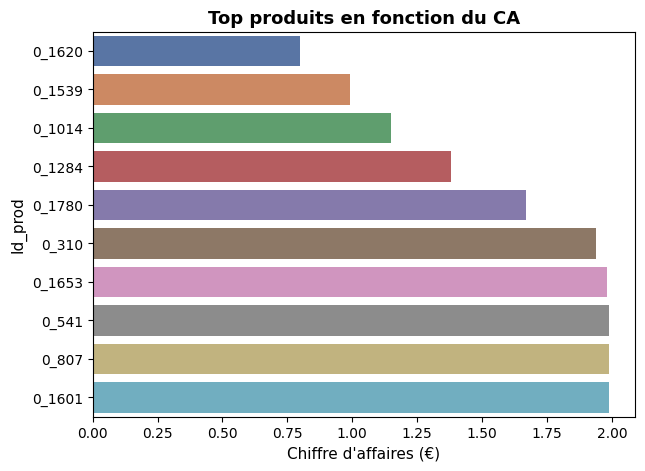

In [43]:
prod_flop10 = dataTurnoverProducts.sort_values('turnover', ascending=True).head(10)
plt.figure(figsize=(7,5))
sns.barplot(x=prod_flop10['turnover'], y=prod_flop10['id_prod'], palette ='deep')
plt.title("Top produits en fonction du CA", fontsize=13, fontweight='bold')
plt.ylabel("Id_prod", fontsize=11)
plt.xlabel("Chiffre d'affaires (€)", fontsize=11)
plt.show()

Le produit ayant pour id '0_1620' est le produit qui a généré le moins de CA avec 0.80 €

#### 2.1.4 Scatterplot CA par produit

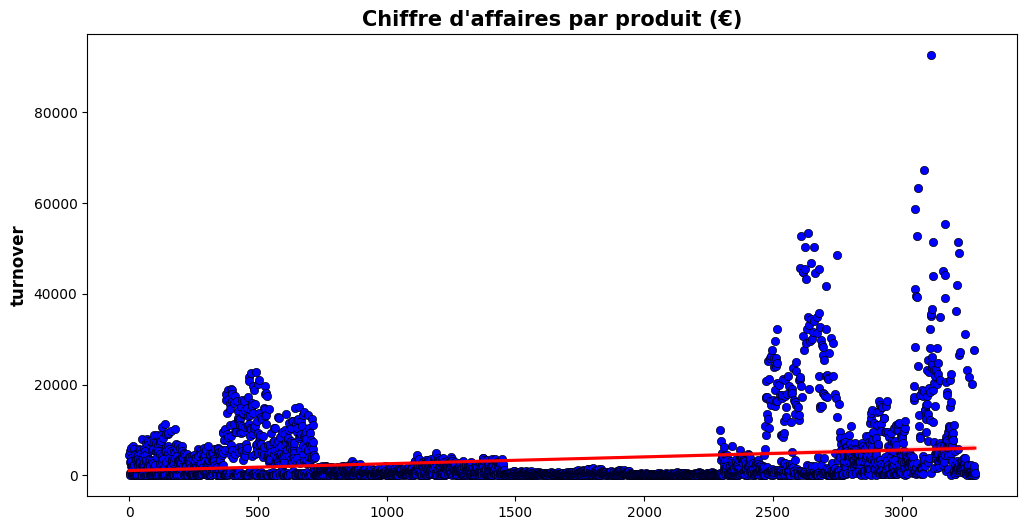

In [44]:
plt.figure(figsize=(12,6))
caproduit = dataTurnoverProducts['turnover']
sns.scatterplot(x=caproduit.index, y=dataTurnoverProducts["turnover"], edgecolor='black', color='blue')
plt.xlabel("Month", size=12, fontweight='bold')
plt.ylabel("Turnover (€)", size=12, fontweight='bold')
sns.regplot(x=caproduit.index, y=dataTurnoverProducts["turnover"], scatter=False, color='red')
plt.title("Chiffre d'affaires par produit (€)", size=15, fontweight='bold')
plt.show()

On constate qu'une grande majorité des produits génèrent moins de 5000 € de chiffre d'affaires. Calculons le pourcentage de produits se situant sous ce seuil:

In [45]:
rateLess5000 = round((len(dataTurnoverProducts[dataTurnoverProducts['turnover'] < 5000]) / len(dataTurnoverProducts) * 100), 2)
rateLess5000

82.17

82.17% des produits ont généré moins de 5 000 € de CA sur la période.

## 2.2 Chiffre d'affaire global

In [46]:
totalTurnover = dataTurnoverProducts['turnover'].sum()
totalTurnover

11556682.129999999

Le chiffre d'affaire total pour la période est de 11 853 728.68 € 

## 2.3 Evolution du chiffre d'affaires 

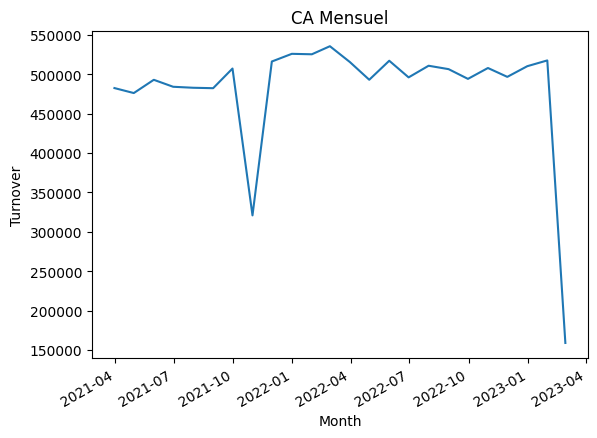

In [47]:
# On visualise l'évolution du chiffre d'affaire au cours du temps 

grouped_by_month = dataSales.groupby(pd.Grouper(key='date', freq='M'))

monthly_turnover = grouped_by_month['price'].sum()

plt.plot(monthly_turnover.index, monthly_turnover)
plt.xlabel('Month')
plt.ylabel('Turnover')
plt.title('CA Mensuel')
plt.gcf().autofmt_xdate()
plt.show()


On constate qu'il y a un drop anormal du chiffre d'affaire vers octobre 2021. Il faudrait voir les chiffres de plus prêt grâce à un pivot table. 

In [48]:
# On crée un pivot table qui affiche le chiffre d'affaires par mois par catégorie 

evolution_ca = dataSales.pivot_table(values="price", index=dataSales['date'].dt.strftime('%Y-%m'), columns="categ", aggfunc="sum")
evolution_ca

categ,0.0,1.0,2.0
date,,,
2021-03,193629.17,186974.17,101837.27
2021-04,205222.46,156138.35,114748.49
2021-05,196186.72,165893.40,130863.35
2021-06,167943.15,189162.04,126983.37
2021-07,144750.79,188523.27,149561.34
2021-08,167737.62,162991.38,151555.79
2021-09,246353.91,190613.78,70272.99
2021-10,199250.83,33762.32,87785.59
2021-11,155909.56,252910.39,107347.78


On constate que c'est effectivement pour le mois d'octobre 2021 qu'il y a un drop mais la répartition par catégorie nous apprend que cela provient majoritairement de la categ 1.

In [49]:
# On calcule la variation du CA entre septembre et octobre

dataSales_monthly = dataSales.groupby(dataSales['date'].dt.strftime('%Y-%m'))['price'].sum().reset_index()
dataSales_monthly.columns = ['month', 'turnover']
september_turnover = dataSales_monthly.loc[6]["turnover"]
october_turnover = dataSales_monthly.loc[7]["turnover"]
variation = round((october_turnover - september_turnover) / september_turnover * 100,2)
variation

-36.76

Entre septembre et octobre 2021, le chiffre d'affaire a baissé de 36,76%. Zoomons sur le mois pour essayer d'en savoir plus:

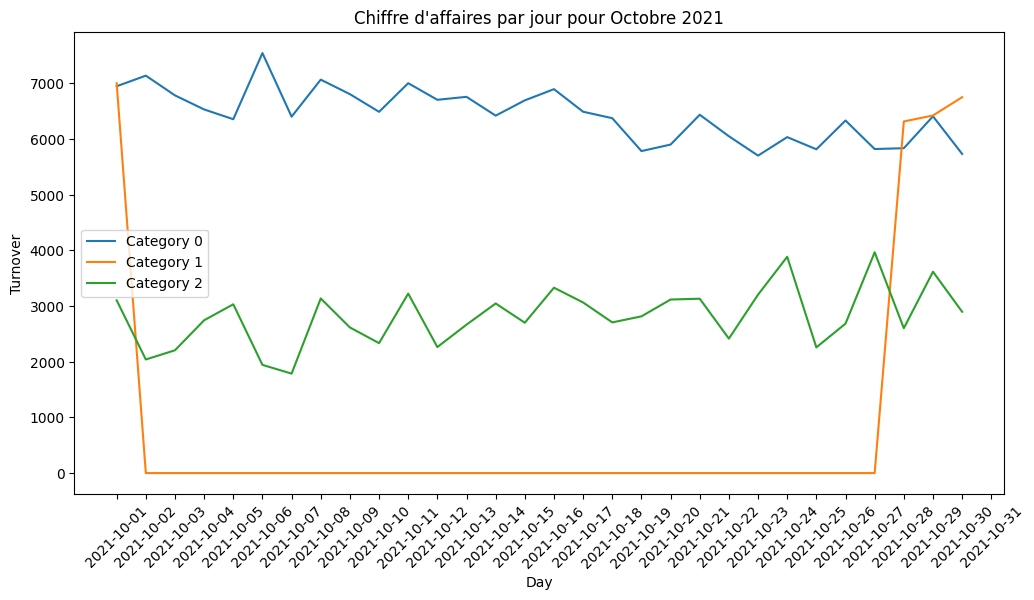

In [50]:
# On crée une visualisation pour octobre 2021

october_sales = dataSales[(dataSales['date'] >= '2021-10-01') & (dataSales['date'] <= '2021-10-31')]
grouped_by_day_categ = october_sales.groupby([pd.Grouper(key='date', freq='D'), 'categ'])
daily_turnover_categ = grouped_by_day_categ['price'].sum()
daily_turnover_pivot = daily_turnover_categ.reset_index().pivot(index='date', columns='categ', values='price').fillna(0)

plt.figure(figsize=(12,6))
plt.plot(daily_turnover_pivot.index, daily_turnover_pivot[0], label='Category 0')
plt.plot(daily_turnover_pivot.index, daily_turnover_pivot[1], label='Category 1')
plt.plot(daily_turnover_pivot.index, daily_turnover_pivot[2], label='Category 2')
plt.xlabel('Day')
plt.ylabel('Turnover')
plt.title("Chiffre d'affaires par jour pour Octobre 2021")
plt.xticks(pd.date_range(start='2021-10-01', end='2021-10-31', freq='D'), rotation=45)
plt.legend()
plt.show()



On est désormais certains qu'il y a zéro vente pour la catégorie 1 pendant 26 jours du mois d'octobre. Cela peut être dû à un bug informatique. 

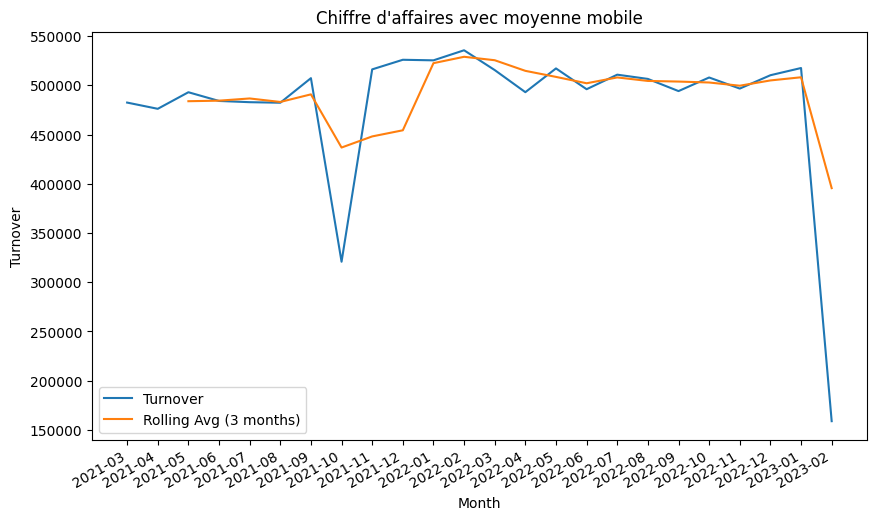

In [51]:
# Graph moyenne mobile

rolling_avg = dataSales_monthly['turnover'].rolling(window=3).mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(dataSales_monthly['month'], dataSales_monthly['turnover'], label='Turnover')
ax.plot(dataSales_monthly['month'], rolling_avg, label='Rolling Avg (3 months)')
ax.set_xlabel('Month')
ax.set_ylabel('Turnover')
ax.set_title("Chiffre d'affaires avec moyenne mobile")
ax.legend()
plt.gcf().autofmt_xdate()
plt.show()

La moyenne mobile, représentée en orange, permet de mieux observer la tendance globale sur la période. Le CA est plutôt stable au lancement du site avant le drop d'octobre 2021 mais remonte fortement le mois suivant pour se stabiliser sur le reste de la période étudie. 

## 2.4 Zoom sur les catégories de produits 

### 2.4.1 Répartition du nombre de produits par catégories

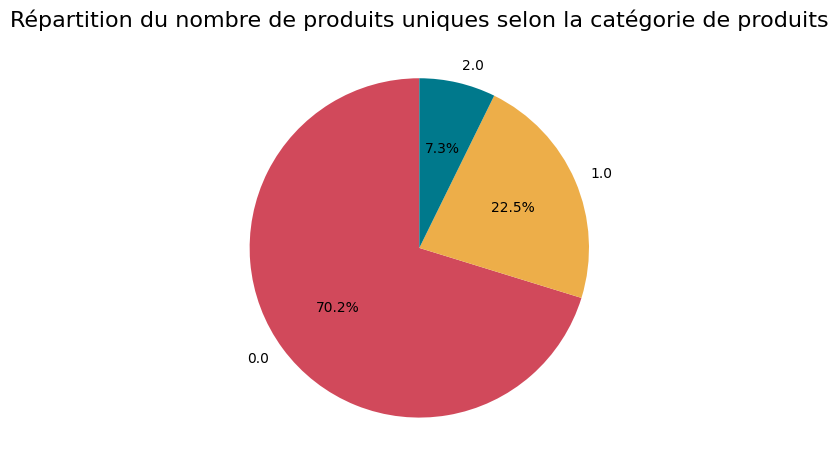

In [52]:
# Pie chart du nombre de produits par catégories

repartition_nb_unique = dataSales.groupby("categ")["id_prod"].nunique()

plt.pie(repartition_nb_unique, 
        labels=repartition_nb_unique.index, 
        colors=["#d1495b", "#edae49", "#00798c"],
        startangle=90,
        autopct='%1.1f%%')
plt.title("Répartition du nombre de produits uniques selon la catégorie de produits", fontsize=16)
plt.tight_layout()
plt.show()

### 2.4.2 Répartition du nombre de ventes selon la catégorie de produits 

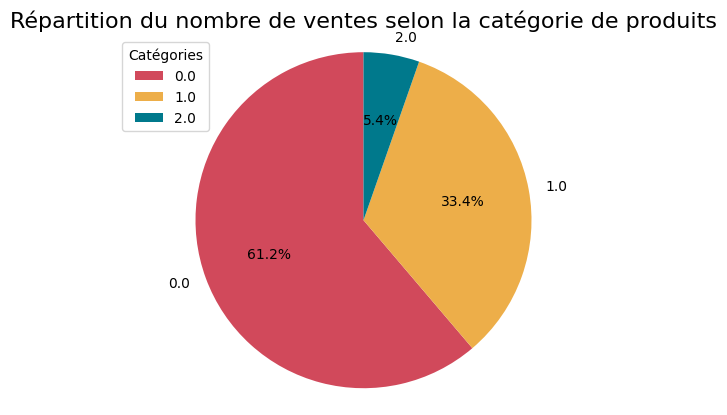

In [53]:
# Pie chart de la répartition des ventes par catégories

repartition_categ = dataSales.groupby("categ")["id_prod"].count()

plt.pie(repartition_categ, labels=repartition_categ.index, colors=["#d1495b", "#edae49", "#00798c"], startangle=90, autopct='%1.1f%%')
plt.axis("equal")

plt.legend(title="Catégories", loc="upper left")

plt.title("Répartition du nombre de ventes selon la catégorie de produits", fontsize=16)

plt.show()


On constate que les produits de catégorie 0 sont les plus vendus , et représentent presque 2 fois le pourcentage des produits de catégorie 1 alors que ceux de categorie 2 ne représentent que 5.4%.

### 2.4.3 Répartition du CA par catégorie 

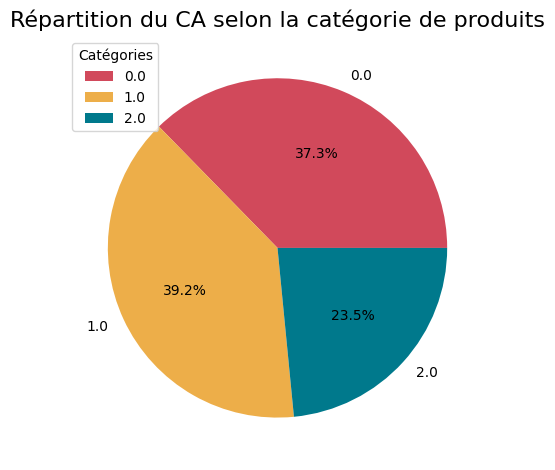

In [54]:
# Pie chart de la répartition du CA par catégorie 

repartition_ca = dataSales.pivot_table(values="price",
                                        index="categ",
                                        aggfunc="sum")

plt.pie(repartition_ca["price"], labels=repartition_ca.index,colors=["#d1495b", "#edae49", "#00798c"],
autopct='%1.1f%%')

plt.legend(title="Catégories", loc="upper left")

plt.title("Répartition du CA selon la catégorie de produits", fontsize=16)
plt.tight_layout()
plt.show()

Les catégories 0 et 1 affichent des pourcentages similaires alors que la catégorie 2 a généré moins de CA. Si on met en perspective cela avec la repartition des ventes par catégorie, on constate que la catégorie 2 représente tout de même une part du CA importante proportionnellement au nombre de ventes des produits qui la composent. 23.5% du CA généré alors que la catégorie 2 ne représente que 5.4% des ventes. Cela peut s'expliquer par des prix plus hauts pour ses produits que les autres catégories. Vérifions cela :

### 2.4.4 Statistiques descriptives des catégories

In [55]:
categ2_data = dataSales[dataSales["categ"] == 2]
categ2_data["price"].describe()

count    35542.00000
mean        76.26515
std         39.81314
min         30.99000
25%         53.99000
50%         62.83000
75%         73.99000
max        300.00000
Name: price, dtype: float64

In [56]:
categ1_data = dataSales[dataSales["categ"] == 1]
categ1_data["price"].describe()

count    221301.00000
mean         20.48742
std           7.58551
min           2.00000
25%          15.81000
50%          19.08000
75%          24.98000
max          80.99000
Name: price, dtype: float64

In [57]:
categ0_data = dataSales[dataSales["categ"] == 0]
categ0_data["price"].describe()

count    405423.000000
mean         10.636248
std           4.933264
min           0.620000
25%           6.290000
50%           9.990000
75%          14.450000
max          40.990000
Name: price, dtype: float64

On a donc la confirmation que le prix moyen des produits de catégorie 2 est nettement plus élevé que pour les autres catégories. Ce sont des produits relativement peu vendus mais à un prix élevé ce qui explique leur importance dans le CA. 

Ces éléments nous permettent d'imaginer que les catégories de produits désignent des formats de livre (poche, roman, royal ou A4) ce qui expliquerait les différences en termes de prix.

## 2.5 Zoom sur les clients 

In [58]:
# On crée un df qui affiche les données clients en ajoutant le chiffre d'affaires généré par chacun d'entre eux 

dataClients = dataSales.groupby("client_id").agg({"price":"sum"})
dataClients = dataClients.reset_index()
dataClients= dataClients.rename(columns={"price":"turnover"})
dataClients = pd.merge(dataClients, dataSales[["client_id", "sex", "birth"]], on="client_id", how="left")
dataClients = dataClients.drop_duplicates()
dataClients = dataClients[(dataClients["client_id"] != 'ct_1') & (dataClients["client_id"] != 'ct_0')]
dataClients

,client_id,turnover,sex,birth
0,c_1,558.18,m,1955.0
39,c_10,1353.60,m,1956.0
97,c_100,254.85,m,1992.0
105,c_1000,2261.89,f,1966.0
230,c_1001,1769.97,m,1982.0
...,...,...,...,...
662003,c_995,189.41,m,1955.0
662017,c_996,1592.80,f,1970.0
662110,c_997,1490.01,f,1994.0
662169,c_998,2393.90,m,2001.0


### 2.5.1 Courbe de Lorenz et indice de Gini

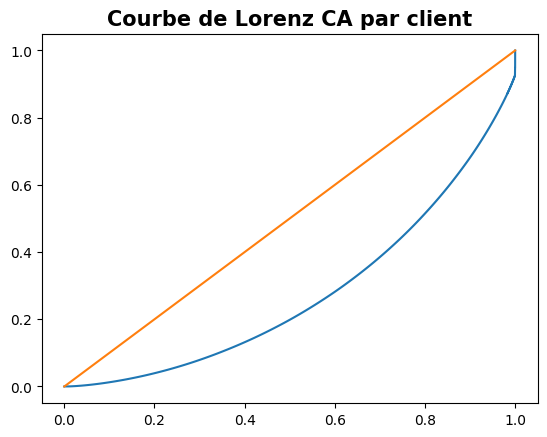

In [59]:
ca = dataClients['turnover'].values
n = len(ca)
lorenz = np.cumsum(np.sort(ca)) / ca.sum()
lorenz = np.append([0],lorenz)

xaxis = np.linspace(0-1/n,1+1/n,len(lorenz))
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1]) #tracer la bisséctrice
plt.title("Courbe de Lorenz CA par client", size=15, fontweight='bold')
plt.show()

La droite orange est la bissectrice et plus la courbe est éloignée de celle-ci, plus la distribution est inégalitaire. Dans ce cas ci, la distribution n'est pas égalitaire. On peut confirmer cela en calculant l'indice de gini : 


In [60]:
# Indice de Gini

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
S = 0.5 - AUC 
gini = 2*S
round(gini,2)

0.45

L'indice de Gini peut être compris entre 0 et 1. Un indice proche de 0 indique une distribution égalitaire et plus il est éloigné de cette valeur, moins elle l'est. Ici, la distribution est plutôt inégalitaire.

### 2.5.2 Top 10 clients par CA généré

In [61]:
top10Clients = dataClients.sort_values('turnover', ascending=False).head(10)
top10Clients

,client_id,turnover,sex,birth
48653,c_1609,315784.52,m,1980.0
341113,c_4958,282157.09,m,1999.0
489751,c_6714,149807.59,f,1968.0
218720,c_3454,110522.44,m,1969.0
203198,c_3263,5223.81,f,1985.0
45914,c_1570,5176.56,f,1979.0
115645,c_2140,5071.18,f,1977.0
605800,c_8026,5050.61,m,1978.0
556998,c_7421,4935.55,m,1978.0
152648,c_2595,4935.18,m,1974.0


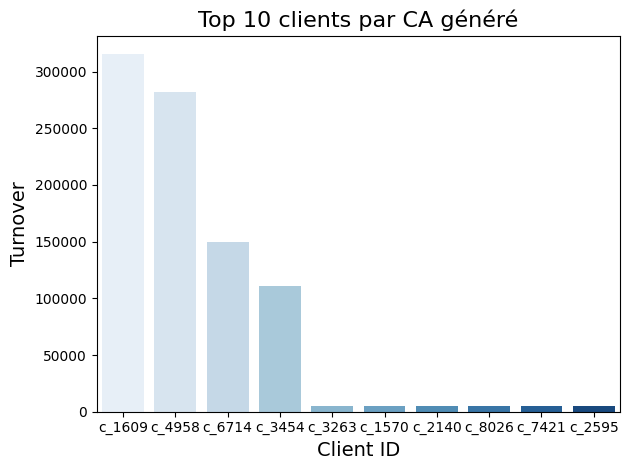

In [62]:
sns.barplot(x=top10Clients["client_id"], y=top10Clients["turnover"], palette=sns.color_palette("Blues", n_colors=10))

plt.xlabel("Client ID", fontsize=14)
plt.ylabel("Turnover", fontsize=14)
plt.title("Top 10 clients par CA généré", fontsize=16)
plt.tight_layout()
plt.show()

Cette visualisation nous apprend qu'il y a un écart énorme entre le CA généré par les 4 premiers clients et le reste des clients. Cela pose problème dans notre analyse, et la question de ces valeurs aberrantes doit être traitée.

In [63]:
bigClients = dataClients.sort_values('turnover', ascending=False).head(4)
bigClientsTurnover = round(bigClients['turnover'].sum(),2)
bigClientsTurnover


858271.64

In [64]:
bigClientsProportion = round((bigClientsTurnover / totalTurnover)*100,2)
bigClientsProportion

7.43

Le top 4 des gros clients a généré à eux seuls 858 271.64 € soit 7.43% du CA total.

Nous travaillons sur les données d'une librairie, on peut donc imaginer qu'il puisse exister des gros clients qui achètent pour revendre par la suite. Il ne serait pas pertinent de conserver ces revendeurs dans notre analyse alors nous faisons le choix de les supprimer. 

In [65]:
dataClients= dataClients.loc[(dataClients['client_id'] != 'c_1609') & (dataClients['client_id'] != 'c_4958') 
         & (dataClients['client_id'] != 'c_6714') & (dataClients['client_id'] != 'c_3454')]

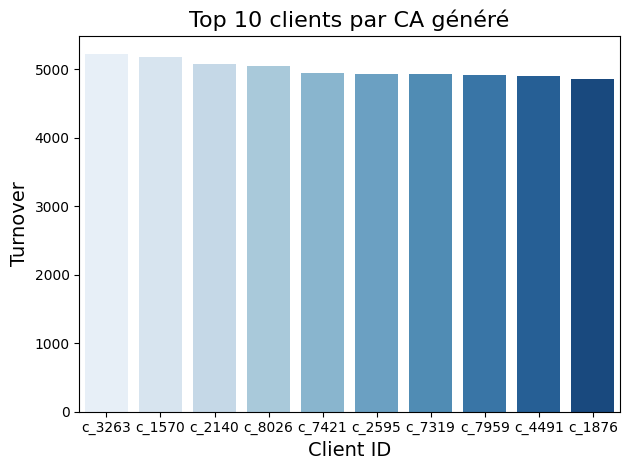

In [66]:
# On produit à nouveau la visualisation sans les valeurs aberrantes

top10Clients = dataClients.sort_values('turnover', ascending=False).head(10)
top10Clients

sns.barplot(x=top10Clients["client_id"], y=top10Clients["turnover"], palette=sns.color_palette("Blues", n_colors=10))

plt.xlabel("Client ID", fontsize=14)
plt.ylabel("Turnover", fontsize=14)
plt.title("Top 10 clients par CA généré", fontsize=16)
plt.tight_layout()
plt.show()


En dehors des gros comptes clients exclus de l'analyse, il n'y pas beaucoup de différence entre le CA généré par les clients le top 10 des clients. Ils ont a peu près tous dépensé 5000 euros.  

### 2.5.3 Flop 10 clients par CA

In [67]:
# On affiche le flop 10 des clients par CA généré 

withPurchaseClients = dataClients[(dataClients["turnover"] != 0)]
flop10Clients = withPurchaseClients.sort_values('turnover', ascending=True).head(10)
flop10Clients

,client_id,turnover,sex,birth
631508,c_8351,6.31,f,1968.0
614788,c_8140,8.30,m,1971.0
612518,c_8114,9.98,m,1962.0
137286,c_240,11.06,m,1998.0
317041,c_4648,11.20,m,2004.0
304117,c_4478,13.36,f,1970.0
427867,c_5962,13.99,f,1997.0
434467,c_6040,15.72,f,1974.0
423130,c_5919,15.98,f,1955.0
415577,c_5829,16.07,f,1989.0


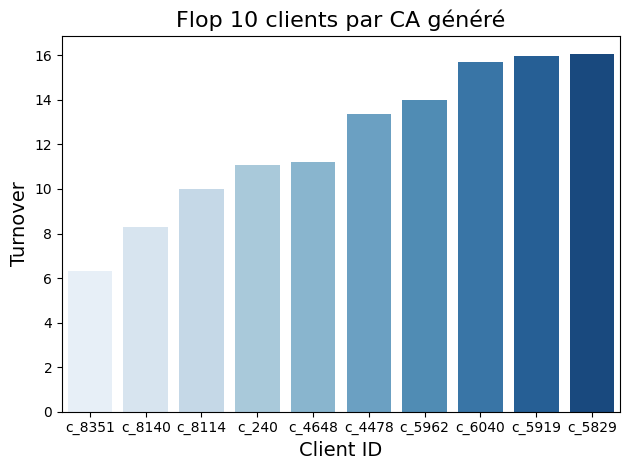

In [68]:
# On crée une visualisation

sns.barplot(x=flop10Clients["client_id"], y=flop10Clients["turnover"], palette=sns.color_palette("Blues", n_colors=10))

plt.xlabel("Client ID", fontsize=14)
plt.ylabel("Turnover", fontsize=14)
plt.title("Flop 10 clients par CA généré", fontsize=16)
plt.tight_layout()
plt.show()

Le client qui a le moins dépensé sur le site a généré 6.31€.

## 2.6 CA par âge

In [69]:
# On ajoute une colonne âge dans le dataframe 

dataClients['age'] = 2023 - dataClients['birth']
dataClients

C:\Users\kamel\AppData\Local\Temp\ipykernel_19432\4250822516.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataClients['age'] = 2023 - dataClients['birth']


,client_id,turnover,sex,birth,age
0,c_1,558.18,m,1955.0,68.0
39,c_10,1353.60,m,1956.0,67.0
97,c_100,254.85,m,1992.0,31.0
105,c_1000,2261.89,f,1966.0,57.0
230,c_1001,1769.97,m,1982.0,41.0
...,...,...,...,...,...
662003,c_995,189.41,m,1955.0,68.0
662017,c_996,1592.80,f,1970.0,53.0
662110,c_997,1490.01,f,1994.0,29.0
662169,c_998,2393.90,m,2001.0,22.0


Pour notre analyse, nous choisissons de créer des classes d'âge qui rendront plus pratiques les visualisations :
- Adolescents, de 15 à 24 ans;
- Adultes, de 25 à 64 ans;
- Ainés, 65 ans et plus.

Source : https://www.statcan.gc.ca/fr/concepts/definitions/age2

In [70]:
# On crée une fonction qui convertit les âges en la classe d'âge correspondante

def classeAge(age):
    if age >= 17 and age <= 24:
        return "Adolescent"
    elif age >= 25 and age <= 64:
        return "Adulte"
    elif age >= 65:
        return "Ainés"

In [71]:
# On applique la fonction au DF

dataClients["Classe d'Âge"] = dataClients["age"].apply(
    classeAge)
dataClients

C:\Users\kamel\AppData\Local\Temp\ipykernel_19432\2862369906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataClients["Classe d'Âge"] = dataClients["age"].apply(


,client_id,turnover,sex,birth,age,Classe d'Âge
0,c_1,558.18,m,1955.0,68.0,Ainés
39,c_10,1353.60,m,1956.0,67.0,Ainés
97,c_100,254.85,m,1992.0,31.0,Adulte
105,c_1000,2261.89,f,1966.0,57.0,Adulte
230,c_1001,1769.97,m,1982.0,41.0,Adulte
...,...,...,...,...,...,...
662003,c_995,189.41,m,1955.0,68.0,Ainés
662017,c_996,1592.80,f,1970.0,53.0,Adulte
662110,c_997,1490.01,f,1994.0,29.0,Adulte
662169,c_998,2393.90,m,2001.0,22.0,Adolescent


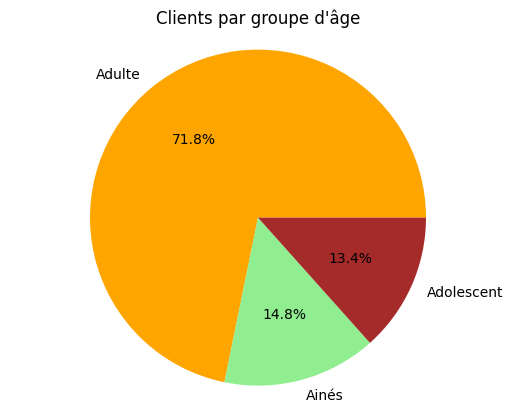

In [72]:
# On visualise la répartition des clients par classe d'âge

values = dataClients["Classe d'Âge"].value_counts()
labels = list(values.index)

fig,ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%', radius=1.5, colors=['orange', 'lightgreen', 'brown'])
ax.axis("equal")
plt.title("Clients par groupe d'âge")
plt.show()



On constate que les + de 25 ans constituent l'écrasante majorité de la base clients du site web. Voyons maintenant comment se distribue le CA entre eux: 

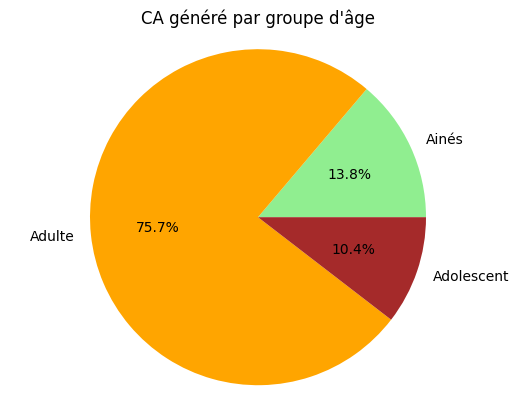

In [73]:
# On visualise la répartition du CA en fonction de la classe d'âge 

labels = dataClients["Classe d'Âge"].unique()
values = dataClients.groupby("Classe d'Âge")['turnover'].sum().tolist()

fig,ax = plt.subplots()
ax.pie(values, labels=labels, autopct='%1.1f%%',colors=['lightgreen', 'orange', 'brown'])
ax.axis("equal")
plt.title("CA généré par groupe d'âge")

plt.show()

La répartition du CA par classe d'âge ressemble à la répartition des clients par classe d'âge lorsque l'on compare les graphiques. Peut-être serait-il pertinent de zoomer afin d'observer la repartition par âge pour avoir plus de détails:

C:\Users\kamel\AppData\Local\Temp\ipykernel_19432\4223875834.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = dataClients.groupby('age').sum()['turnover']


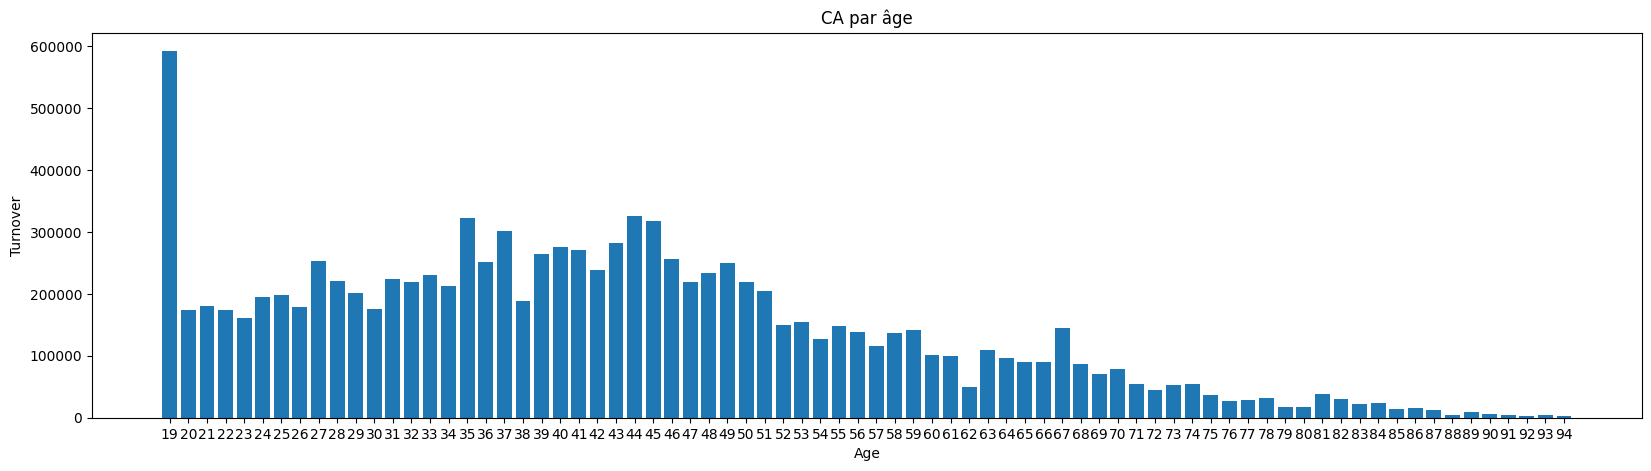

In [74]:
# On crée un barplot afin de visualiser la répartition du CA par âge des clients

grouped = dataClients.groupby('age').sum()['turnover']

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(grouped.index, grouped.values)
ax.set_xlabel('Age')
ax.set_ylabel('Turnover')
ax.set_title('CA par âge')
plt.xticks(dataClients['age'].unique())
plt.show()

In [75]:
# On calcule le CA généré par les clients de 19 ans 

f_19 = dataClients.loc[dataClients['age'] == 19]
total_turnover_19 = f_19['turnover'].sum()
rate19=round((total_turnover_19 / totalTurnover)*100,2)
rate19


5.13

On constate que les clients de 19 ans sont ceux qui ont généré le plus de CA avec 5.13% à eux seuls. On observe également que le CA se concentre entre les 30-50 ans avec une baisse graduelle à partir de cet âge. 

## 2.7 CA par genre

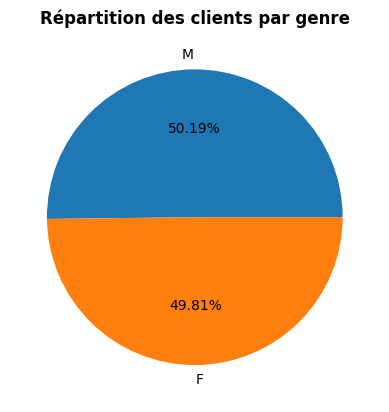

In [76]:
# Répartition des clients par genre 

labels = ['M', 'F']
plt.pie(dataSales["sex"].value_counts(), autopct='%.2f%%', labels=labels, pctdistance=0.6)
plt.title("Répartition des clients par genre", fontsize=12, fontweight='bold')
plt.show()

Il y a très légèrement plus d'hommes que de femmes dans notre base clients. 

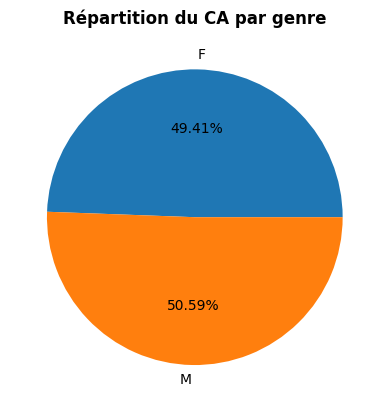

In [77]:
# Répartition du CA par genre

# création de la colonne "CA" en groupant les mêmes catégories et en faisant la somme des prix :
CA_genre = pd.DataFrame(dataSales.groupby('sex')['price'].sum()).reset_index()
CA_genre.rename(columns = {'price':'turnover'}, inplace=True)

# Diagramme de camembert
labels = ['F', 'M']
plt.pie(CA_genre["turnover"], autopct='%.2f%%', labels=labels, pctdistance=0.6)
plt.title("Répartition du CA par genre", fontsize=12, fontweight='bold')
plt.show()

Le CA est à peu près équitablement réparti entre hommes et femmes mais les hommes ont généré légèrement plus de CA.

# 3 Analyse des corrélations entre variables 

## 3.1 Corrélation entre le genre et la catégorie de livre achetée 

Ici, nous souhaitons déterminer si les variables 'sex' et 'categ' sont liées. Il s'agit de 2 variables catégoriques et nous avons donc choisi d'effectuer un test chi-2 qui pour tester la dépendance entre elles. Nous formulons 2 hypothèses:
- H1 : Les variables sont indépendantes 
- H2 : Il existe une dépendance entre elles 

In [78]:
# On enlève les gros clients de notre DF pour effectuer le test 

excluded_ids = ['c_1609', 'c_4958', 'c_6714', 'c_3454']
dataSalesFiltered = dataSales[~dataSales['client_id'].isin(excluded_ids)]

In [79]:
# On crée un tableau de contingence 

X = "sex"
Y = "categ"

contTable = dataSalesFiltered[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
contTable

categ,0.0,1.0,2.0
sex,,,
f,195947,108437,16523
m,181970,98419,15487


In [80]:
contTableTotal = dataSalesFiltered[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
contTableTotal

categ,0.0,1.0,2.0,Total
sex,,,,
f,195947,108437,16523,320907
m,181970,98419,15487,295876
Total,377917,206856,32010,616783


In [81]:
# On effectue le test chi-2

chi2, pval, dof, expected = chi2_contingency(contTable)

# On affiche la statistique chi-2
print("Chi-square statistic = ", round(chi2))
# On affiche la P-Value
print("P-value = ", pval)
# On affiche les degrés de liberté 
print("Degrees of freedom = ", dof)
# On affiche les effectifs attendus 
print("Expected frequencies = ")
print(expected)


Chi-square statistic =  20
P-value =  4.9540557851278636e-05
Degrees of freedom =  2
Expected frequencies = 
[[196627.03206638 107625.43454019  16654.53339343]
 [181289.96793362  99230.56545981  15355.46660657]]


Notre statistique chi-2 affiche 20 ce qui est supérieur à la valeur de référence sur la table du chi-2 lorsque l'on se base sur des degrés de liberté de 2 et un niveau de significativité de 0.05. Ainsi, on peut infirmer l'hypothèse par défaut selon laquelle il n'existe aucune relation entre les variables 'sex' et 'category'

Notre p-value de 4.9540557851278636e-05 est une probabilité très faible en comparaison au niveau de significativité par défaut qui est 0.05. Nous pouvons donc dire que l'association entre les deux variables n'est certainement pas due à la chance . 

## 3.2 Corrélations entre l'âge des clients et les autres variables

### 3.2.1 Corrélation entre l'âge des clients et le montant total des achats

In [82]:
# On exclut l'outlier que nous avons repéré dans la partie 2.6

dataClientsFiltered = dataClients.loc[dataClients["age"] != 19]


Text(0.5, 1.0, 'Histogramme de distribution')

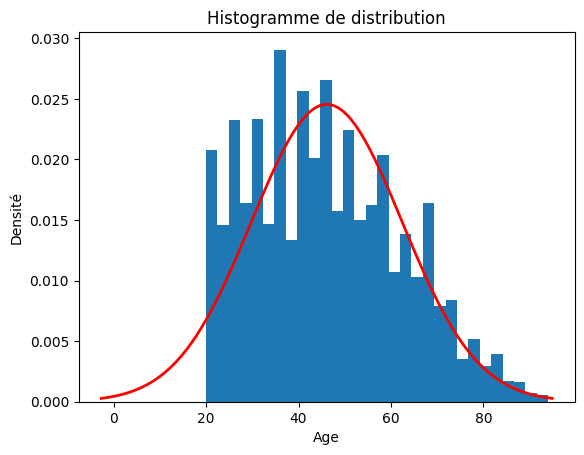

In [83]:
# On teste la normalité de la distribution des variables

plt.hist(dataClientsFiltered['age'], bins=30, density=True)


mu, std = norm.fit(dataClientsFiltered['age'])
x = np.linspace(mu - 3*std, mu + 3*std, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, 'r-', linewidth=2)
plt.xlabel('Age')
plt.ylabel('Densité')
plt.title('Histogramme de distribution')

In [84]:
# Shapiro-Wilk test
stat, p = shapiro(dataClientsFiltered['age'])
print('Test statistic: %.3f, p-value: %.3f' % (stat, p))

Test statistic: 0.972, p-value: 0.000


d:\Python 3.11\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


L'hypothèse nulle selon laquelle la variable 'age' est normalement distribuée est rejetée.

Text(0.5, 1.0, 'Histogramme de distribution')

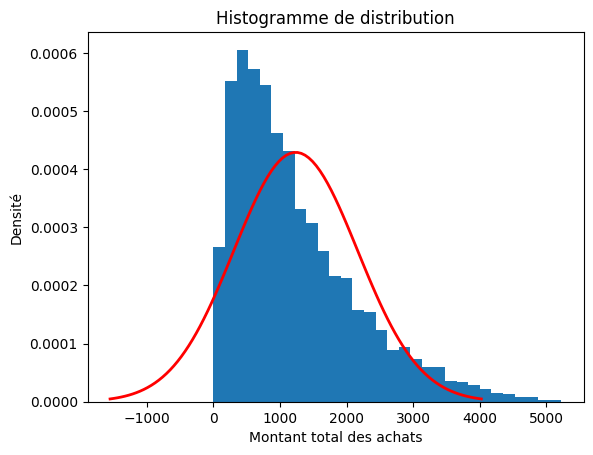

In [85]:
TurnoverAge = dataClientsFiltered[['age', 'turnover']]
plt.hist(TurnoverAge['turnover'], bins=30, density=True)


mu, std = norm.fit(TurnoverAge['turnover'])
x = np.linspace(mu - 3*std, mu + 3*std, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, 'r-', linewidth=2)
plt.xlabel('Montant total des achats')
plt.ylabel('Densité')
plt.title('Histogramme de distribution')

In [86]:
# Shapiro-Wilk test
stat, p = shapiro(TurnoverAge['turnover'])
print('Test statistic: %.3f, p-value: %.3f' % (stat, p))

Test statistic: 0.903, p-value: 0.000


d:\Python 3.11\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


L'hypothèse nulle selon laquelle la variable 'montant_total_achats' est normalement distribuée est rejetée.

Ici, l'âge des clients et le montant total des achats sont deux variables quantitatives. Nous allons utiliser un modèle de regression linéaire pour tester la corrélation entre les deux variables:

Coefficient:  [[-11.14324806]]
Intercept:  [1749.6023563]


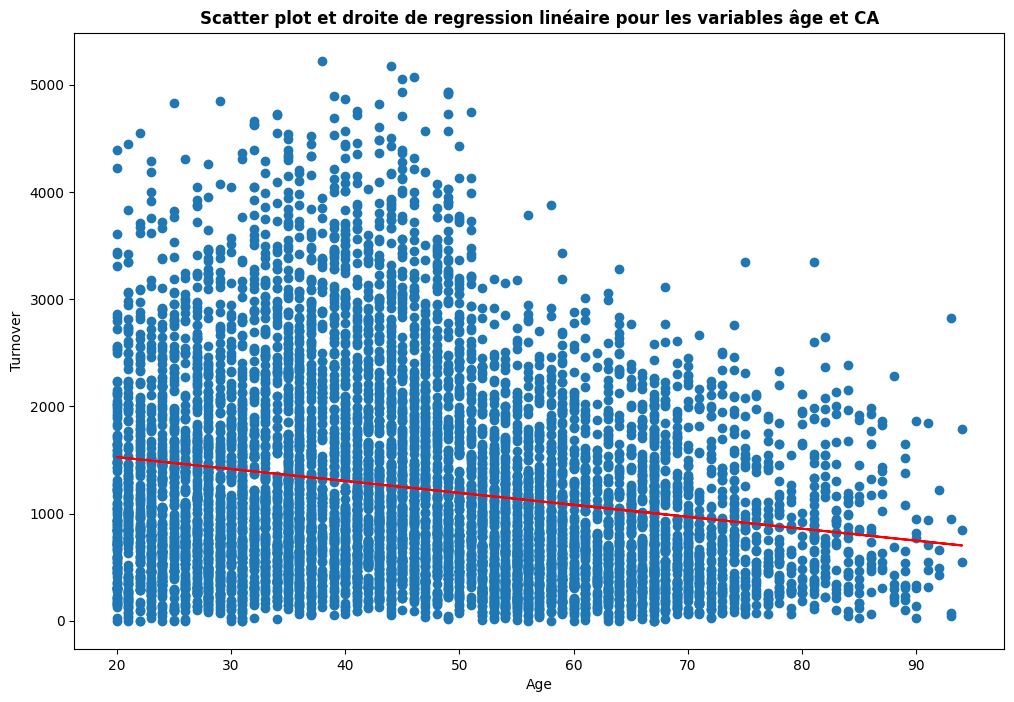

In [87]:
# On crée un modèle de regression linéaire 
model = LinearRegression()
model.fit(TurnoverAge[['age']], TurnoverAge[['turnover']])
print("Coefficient: ", model.coef_)
print("Intercept: ", model.intercept_)

# On crée un scatterplot pour visualiser la dispersion et la droite de régression linéaire
plt.figure(figsize=(12, 8)) 
plt.scatter(TurnoverAge[['age']], TurnoverAge[['turnover']])
plt.plot(TurnoverAge[['age']], model.predict(TurnoverAge[['age']]), color='red')
plt.xlabel('Age')
plt.ylabel('Turnover')
plt.title("Scatter plot et droite de regression linéaire pour les variables âge et CA", fontsize=12, fontweight='bold')
plt.show()


Le coefficient qui représente la pente de la regréssion linéaire est environ de -11.14 ce qui indique qu'il existe une corrélation négative entre le CA généré et l'âge des clients. Plus l'âge du client augmente, plus le chiffre d'affaire généré baisse.

### 3.2.2 Corrélation entre l'âge des clients et la fréquence d'achats

In [88]:
# On met à jour le df en ajoutant les colonnes qui nous permettront de réaliser notre analyse

dataSalesFiltered.loc[:, 'date'] = pd.to_datetime(dataSalesFiltered['date'])
dataSalesFiltered.loc[:, 'age'] = 2023 - dataSalesFiltered['birth']
dataSalesFiltered.loc[:, 'mois'] = dataSalesFiltered['date'].dt.month
dataSalesFiltered.loc[:, 'taille_panier'] = dataSalesFiltered['session_id'].map(dataSalesFiltered['session_id'].value_counts())

C:\Users\kamel\AppData\Local\Temp\ipykernel_19432\1602815039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSalesFiltered.loc[:, 'date'] = pd.to_datetime(dataSalesFiltered['date'])
C:\Users\kamel\AppData\Local\Temp\ipykernel_19432\1602815039.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataSalesFiltered.loc[:, 'date'] = pd.to_datetime(dataSalesFiltered['date'])
C:\Users\kamel\AppData\Local\Temp\ipykernel_19432\1602815039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [89]:
# On crée un pivot table qui affiche le nombre d'achats total par mois pour chaque client 

frequency = dataSalesFiltered.pivot_table(index=["client_id", "age"], columns=["mois"], values=["taille_panier"], aggfunc=sum).reset_index()
frequency = frequency.fillna(0)
frequency.columns = ["client_id", "age", '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
frequency

,client_id,age,1,2,3,4,5,6,7,8,9,10,11,12
0,c_1,68.0,4.0,1.0,2.0,2.0,1.0,4.0,7.0,3.0,2.0,3.0,29.0,5.0
1,c_10,67.0,9.0,0.0,7.0,34.0,1.0,5.0,5.0,14.0,7.0,8.0,2.0,38.0
2,c_100,31.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,9.0,1.0,0.0,0.0,0.0
3,c_1000,57.0,16.0,41.0,54.0,11.0,26.0,6.0,3.0,11.0,8.0,9.0,23.0,27.0
4,c_1001,41.0,10.0,25.0,37.0,21.0,1.0,26.0,16.0,9.0,21.0,14.0,52.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8591,c_995,68.0,0.0,0.0,0.0,1.0,4.0,0.0,4.0,4.0,1.0,1.0,9.0,0.0
8592,c_996,53.0,8.0,2.0,22.0,5.0,12.0,9.0,11.0,18.0,6.0,7.0,6.0,19.0
8593,c_997,29.0,17.0,16.0,41.0,1.0,5.0,4.0,5.0,18.0,38.0,2.0,20.0,16.0
8594,c_998,22.0,4.0,6.0,8.0,0.0,18.0,0.0,91.0,1.0,11.0,4.0,1.0,81.0


In [90]:
frequency["achats_mois_moy"] = frequency.iloc[:, 3:15].mean(axis=1)
frequency["achats_mois_moy"] = round(frequency["achats_mois_moy"],2)
frequency = frequency[["client_id", "age", "achats_mois_moy"]]
frequency

,client_id,age,achats_mois_moy
0,c_1,68.0,5.36
1,c_10,67.0,11.00
2,c_100,31.0,1.45
3,c_1000,57.0,19.91
4,c_1001,41.0,24.36
...,...,...,...
8591,c_995,68.0,2.18
8592,c_996,53.0,10.64
8593,c_997,29.0,15.09
8594,c_998,22.0,20.09


Text(0.5, 1.0, 'Histogramme de distribution')

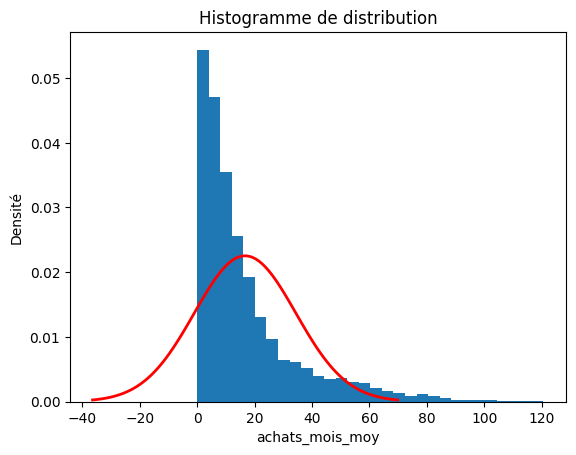

In [91]:
plt.hist(frequency['achats_mois_moy'], bins=30, density=True)


mu, std = norm.fit(frequency['achats_mois_moy'])
x = np.linspace(mu - 3*std, mu + 3*std, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, 'r-', linewidth=2)
plt.xlabel('achats_mois_moy')
plt.ylabel('Densité')
plt.title('Histogramme de distribution')

In [92]:
# Shapiro-Wilk test
stat, p = shapiro(frequency['achats_mois_moy'])
print('Test statistic: %.3f, p-value: %.3f' % (stat, p))

Test statistic: 0.786, p-value: 0.000


d:\Python 3.11\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


L'hypothèse nulle selon laquelle la variable 'achats_mois_moy' est normalement distribuée est rejetée.

In [93]:
# On crée un modèle de régression linéaire

X = frequency[['age']]
y = frequency['achats_mois_moy']

model = LinearRegression()
model.fit(X, y)

print('Coefficients: ', model.coef_)
print('Intercept: ', model.intercept_)

Coefficients:  [-0.04803855]
Intercept:  18.811007480838214


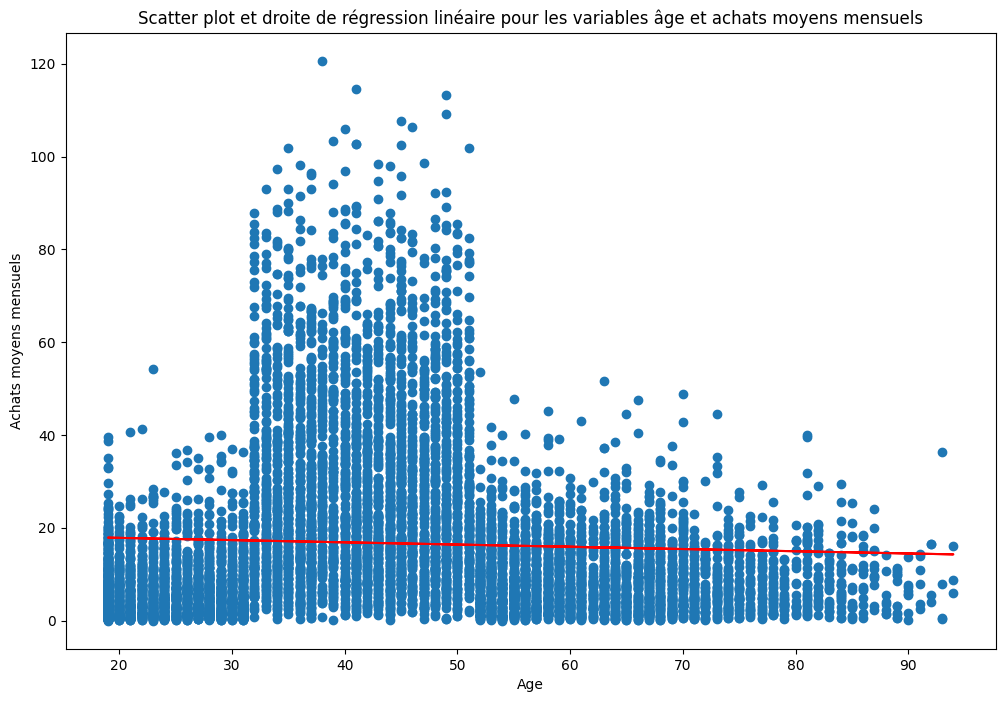

In [94]:
# On crée un scatterplot pour visualiser la dispersion et la droite de régression linéaire

plt.figure(figsize=(12, 8))
plt.scatter(X, y)

plt.plot(X, model.predict(X), color='red')

plt.xlabel('Age')
plt.ylabel('Achats moyens mensuels')
plt.title('Scatter plot et droite de régression linéaire pour les variables âge et achats moyens mensuels')
plt.show()

Le coefficient et la droite de regression laissent penser qu'il y a une corrélation négative entre les variables, autrement dit que plus l'âge augmente, plus la fréquence d'achats baisse. Cependant, la représentation graphique nous montre qu'entre 30 et 50 ans, la fréquence est beaucoup plus élevée que pour les autres tranches d'âge.


On reproduit une visualisation cette fois avec la méthode LOWESS qui permet de mieux identifier les tendances :

In [95]:
fig = px.scatter(
    frequency,
    x='age',
    y='achats_mois_moy',
    color_discrete_sequence=["blue"],
    title="Scatter plot et régression linéaire (LOWESS) âge et achats moyens mensuels</b>",
    trendline="lowess",
    trendline_color_override="red"
)
fig.update_layout(title_x=0.5)
fig.show()

On constate donc une tendance haussière pour la fréquence d'achats mensuelle en fonction de l'âge jusque 50 ans et une tendance baissière à partir de 50 ans.

### 3.2.3 Corrélation entre l'âge des clients et la taille du panier moyen

In [96]:
# On crée un DF qui regroupe l'âge et le panier moyen pour chaque client 

panierMoy = pd.DataFrame(dataSalesFiltered.groupby(["client_id", "age"])["taille_panier"].mean()).reset_index()
panierMoy["taille_panier"] = round(panierMoy["taille_panier"],2)
panierMoy["taille_panier"] = panierMoy["taille_panier"].fillna(0)
panierMoy.rename(columns={"taille_panier": "panier_moyen"}, inplace=True)
panierMoy.head()

,client_id,age,panier_moyen
0,c_1,68.0,1.62
1,c_10,67.0,2.24
2,c_100,31.0,2.00
3,c_1000,57.0,1.88
4,c_1001,41.0,2.84


Text(0.5, 1.0, 'Histogramme de distribution')

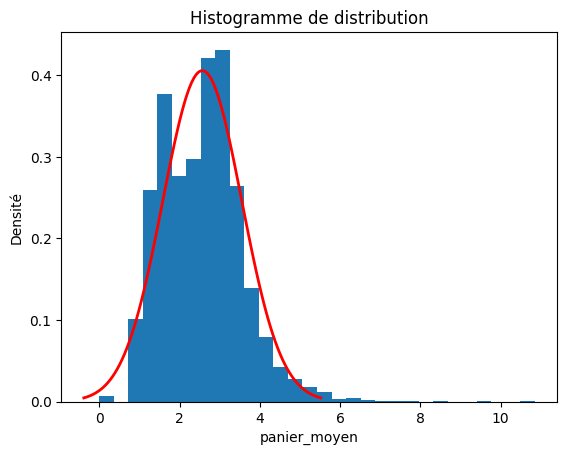

In [97]:
# Histogramme pour observer la distribution

plt.hist(panierMoy['panier_moyen'], bins=30, density=True)


mu, std = norm.fit(panierMoy['panier_moyen'])
x = np.linspace(mu - 3*std, mu + 3*std, 100)
y = norm.pdf(x, mu, std)
plt.plot(x, y, 'r-', linewidth=2)
plt.xlabel('panier_moyen')
plt.ylabel('Densité')
plt.title('Histogramme de distribution')

In [98]:
# Shapiro-Wilk test
stat, p = shapiro(panierMoy['panier_moyen'])
print('Test statistic: %.3f, p-value: %.3f' % (stat, p))

Test statistic: 0.964, p-value: 0.000


d:\Python 3.11\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning:

p-value may not be accurate for N > 5000.



L'hypothèse nulle selon laquelle la variable 'panier_moyen' est normalement distribuée est rejetée.

Ici, nous avons deux variables quantitatives et nous analyserons la corrélation par régression linéaire également. 

In [99]:
# On crée un modèle de régression linéaire

X = panierMoy[['age']]
y = panierMoy['panier_moyen']

model = LinearRegression()
model.fit(X, y)

print('Coefficients: ', model.coef_)
print('Intercept: ', model.intercept_)


Coefficients:  [-0.00925906]
Intercept:  2.98155382739451


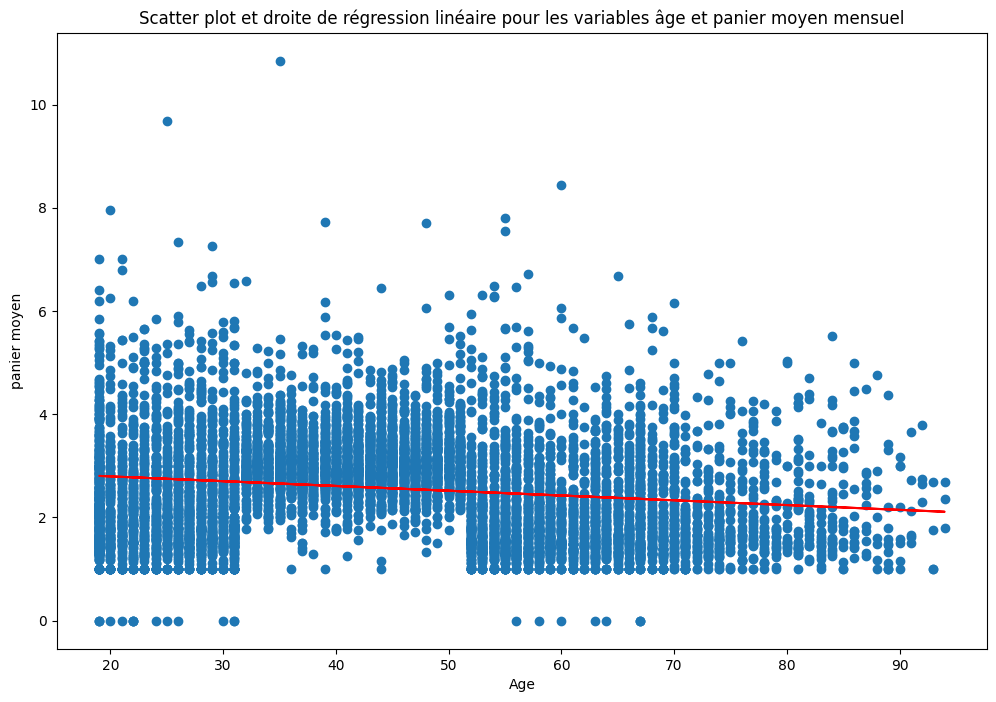

In [100]:
plt.figure(figsize=(12, 8))
plt.scatter(X, y)

plt.plot(X, model.predict(X), color='red')

plt.xlabel('Age')
plt.ylabel('panier moyen')
plt.title('Scatter plot et droite de régression linéaire pour les variables âge et panier moyen mensuel')
plt.show()

Le coefficient montre qu'il existe un lien de corrélation négative entre les deux variables. 

### 3.2.4 Corrélation entre l'âge des clients et les catégories de livres achetées

Nous allons opter pour un test non-paramétrique afin de tester le lien entre les deux variables. Nous avons choisi le test de Kruskal-Wallis dont les hypothèses sont les suivantes : 
- Hypothèse nulle (H0) : Les distributions des différents groupes sont égales.
- Hypothèse alternative (H1) : Au moins une des distributions est différente des autres.

In [101]:
# Effectuer le test de Kruskal-Wallis

dataCorrAgeCateg = dataSalesFiltered.notna()
stat, p_value = kruskal(dataCorrAgeCateg['age'], dataCorrAgeCateg['categ'])

# Afficher les résultats
print('Statistique de test :', stat)
print('P-valeur :', p_value)

Statistique de test : 0.09091231448032405
P-valeur : 0.7630205248847867


Ces résultats suggèrent que les groupes ne sont pas significativement différents les uns des autres en termes de distribution de population. En d'autres termes, il n'y a pas suffisamment de preuves pour rejeter l'hypothèse nulle que les groupes ont la même distribution de population.

On effectue maintenant un test de corrélation de Spearman :

In [102]:
# Calcul de la corrélation de Spearman
corr, p_value = spearmanr(dataCorrAgeCateg['age'], dataCorrAgeCateg['categ'])

print("Corrélation de Spearman : {:.3f}".format(corr))
print("P-valeur : {:.3f}".format(p_value))

Corrélation de Spearman : -0.000
P-valeur : 0.978


Dans ce cas, la corrélation de Spearman est très proche de zéro (-0.000), ce qui suggère une absence de corrélation ou une corrélation très faible entre les variables "age" et "categ". La p-valeur élevée (0.978) confirme que cette corrélation n'est pas statistiquement significative, ce qui signifie que nous ne pouvons pas rejeter l'hypothèse nulle selon laquelle il n'y a pas de corrélation significative entre les variables.

# Conclusion générale

- Il y a des données issues de test dans notre jeu de données. Nous les avons supprimées mais il faut consulter l'équipe en charge du site web pour comprendre leur origine. 

- Il existe un certain nombre de clients n'ayant jamais passé commande et de produits n'ayant jamais été acheté.

- Il n'y a aucune info sur le prix et la catégorie du produit ayant pour id 0_2245 bien qu'il ait été vendu 221 fois. 

- Le chiffre d'affaire total pour la période est de 11 853 728.68 € 

- Il y a zéro vente pour la catégorie 1 de produits les 26 premiers jours du mois d'octobre. Cela peut être dû à un bug informatique  et c'est un élément à investiguer du côté de l'équipe en charge du site web. 

- Le top 4 des plus gros clients a généré à eux seuls 858 271.64 € soit 7.43% du CA total. Cela met en évidence l'existence de clients avec un profil de revendeur. 

- Corrélation négative entre âge des clients et CA généré.

- Tendance haussière pour la fréquence d'achats mensuelle en fonction de l'âge jusque 50 ans et tendance baissière à partir de 50 ans.

- Corrélation négative entre âge et panier moyen